In [50]:
import os
import pickle
import pandas as pd
from pathlib import Path
from pku_autonomous_driving import io, util, dataset, resnet, centernet, training, graphics, transform, const

import importlib
importlib.reload(io)
importlib.reload(util)
importlib.reload(dataset)
importlib.reload(resnet)
importlib.reload(centernet)
importlib.reload(training)
importlib.reload(graphics)
importlib.reload(transform)
importlib.reload(const)

<module 'pku_autonomous_driving.const' from '/Users/argon/workspace/managed/pku-autonomous-driving/pku_autonomous_driving/const.py'>

In [43]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
import torchvision
from pku_autonomous_driving.transform import CropBottomHalf, PadByMean, Resize, Normalize, DropPointsAtOutOfScreen, CreateMask, CreateRegr, ToCHWOrder
from pku_autonomous_driving.const import IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE

train_transform = torchvision.transforms.Compose([
    CropBottomHalf(),
    PadByMean(),
    Resize(IMG_WIDTH, IMG_HEIGHT),
    Normalize(),
    DropPointsAtOutOfScreen(IMG_WIDTH, IMG_HEIGHT),
    CreateMask(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    CreateRegr(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    ToCHWOrder()
])

In [23]:
from pku_autonomous_driving.dataset import CarDataset
from pku_autonomous_driving.training import create_data_loader

train, dev = io.load_train_data()

train_dataset = CarDataset(train, transform=train_transform)
dev_dataset = CarDataset(dev, transform=train_transform)

train_loader = create_data_loader(train_dataset, batch_size=1)
dev_loader = create_data_loader(dev_dataset, batch_size=1)

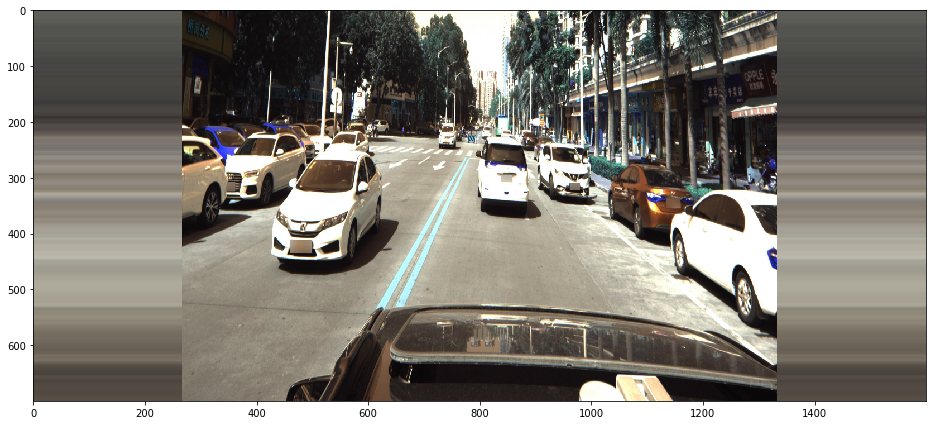

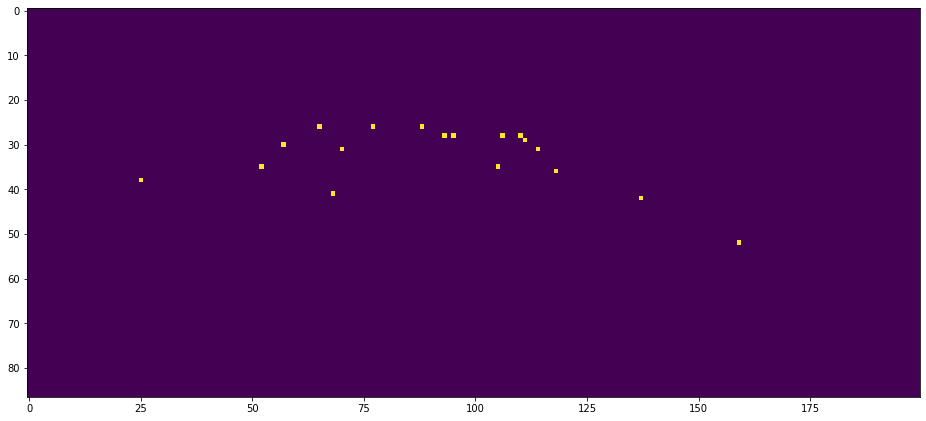

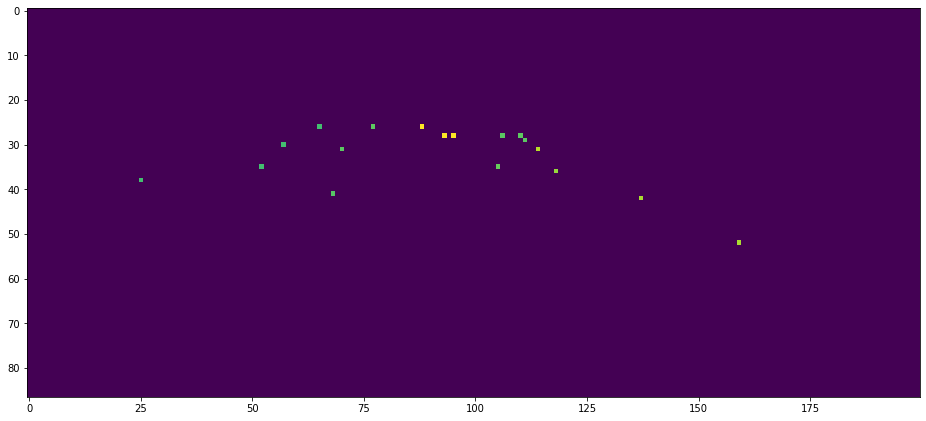

In [24]:
import matplotlib.pyplot as plt
import numpy as np

data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]
plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [25]:
base_model = resnet.resnext50_32x4d(pretrained=False)
model = centernet.CentResnet(base_model, 8)

setup_kwargs = {"model": model, "device": device}
if 'INITIAL_WEIGHTS' in os.environ:
    #util.setup_model(model, device, Path("../input/pkuautonomousdrivingtraining/resnext50.pth"))
    setup_kwargs["path"] = Path(os.environ["INITIAL_WEIGHTS"])
util.setup_model(**setup_kwargs)
print(setup_kwargs)

{'model': CentResnet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (do

In [66]:
n_epochs = 6

try:
    #util.setup_model(model, device, Path("../input/pkuautonomousdrivingtraining/history.pickle"))
    history = pickle.load(Path(os.environ["INITIAL_HISTORY"]).open('rb'))
    beg_epoch = math.ceil(history.index[-1])
except:
    history = pd.DataFrame()
    beg_epoch = 0
end_epoch = beg_epoch + n_epochs

In [616]:
%%time
from torch import optim
from torch.optim import lr_scheduler
import pandas as pd
import pickle


optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

for epoch in range(beg_epoch, end_epoch):
    training.clean_up()
    training.train(model, optimizer, exp_lr_scheduler, train_loader, epoch, device, history)
    training.evaluate(model, dev_loader, epoch, device, history)
    
    with open('./history.pickle', 'wb') as fp:
        pickle.dump(history , fp)
    
    torch.save(model.state_dict(), f'./resnext50_{epoch}.pth')
    torch.save(model.state_dict(), './resnext50.pth')

KeyboardInterrupt: 

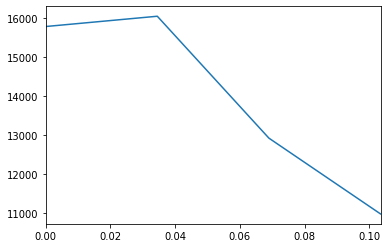

In [55]:
history['train_loss'].iloc[:].plot();

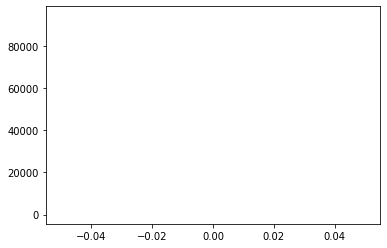

In [56]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

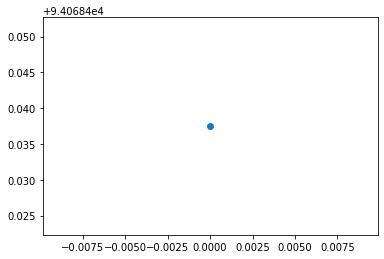

In [57]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

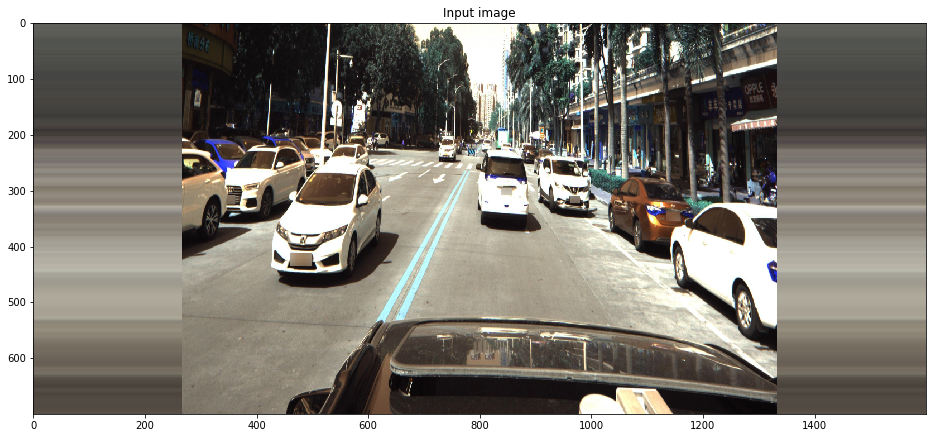

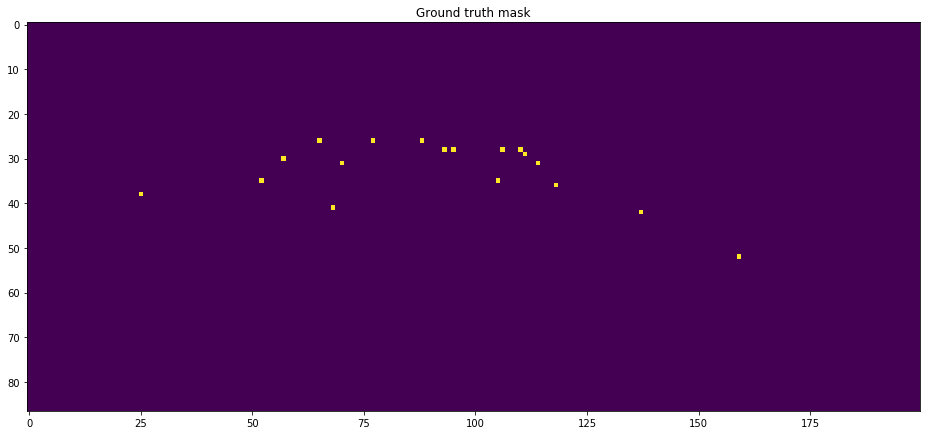

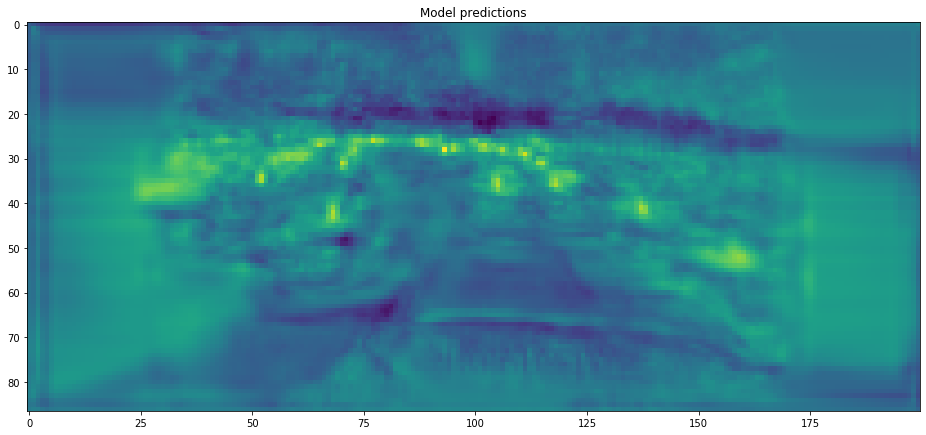

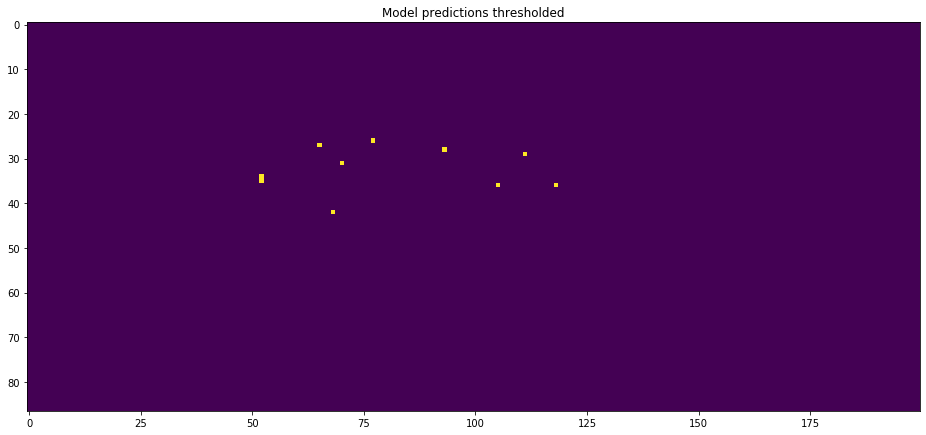

In [30]:
data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

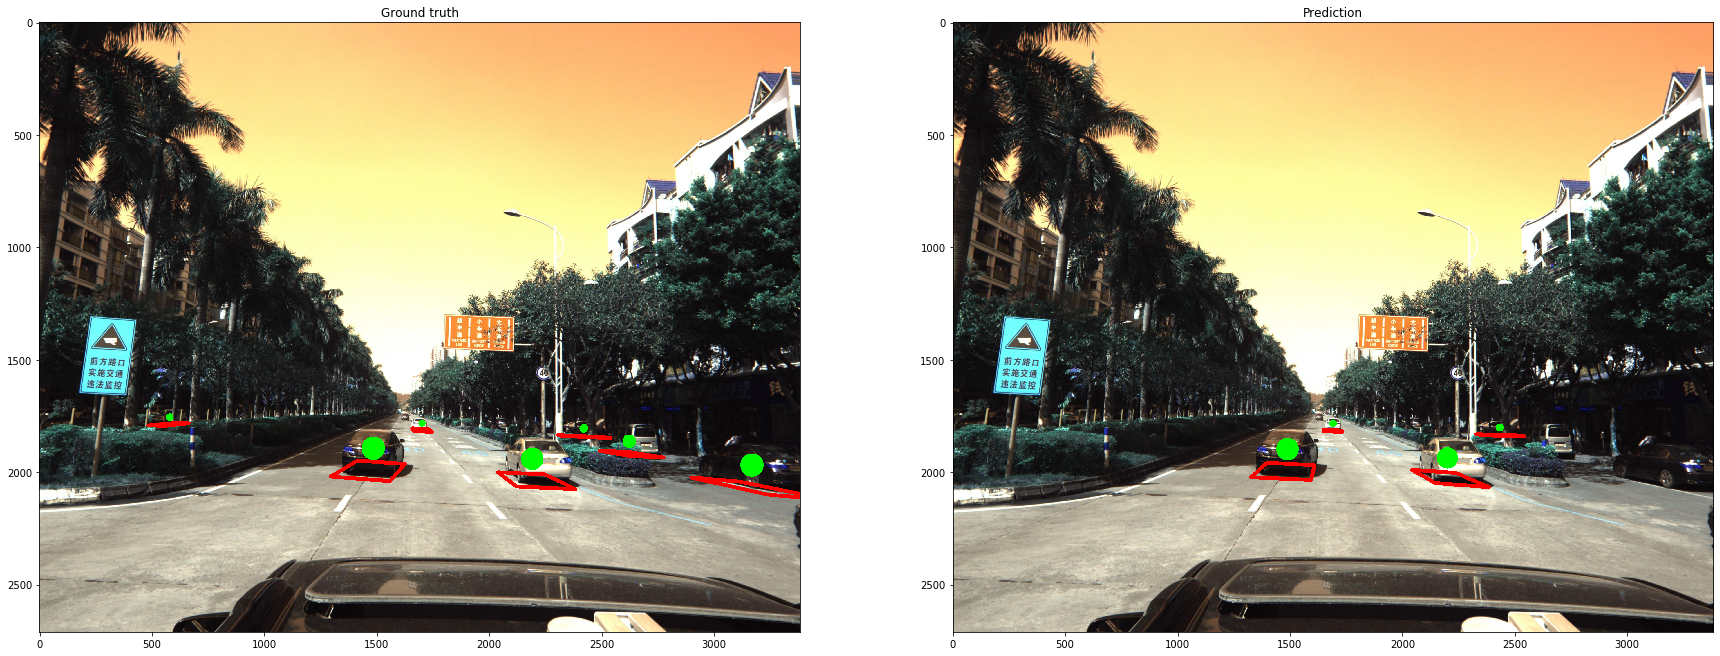

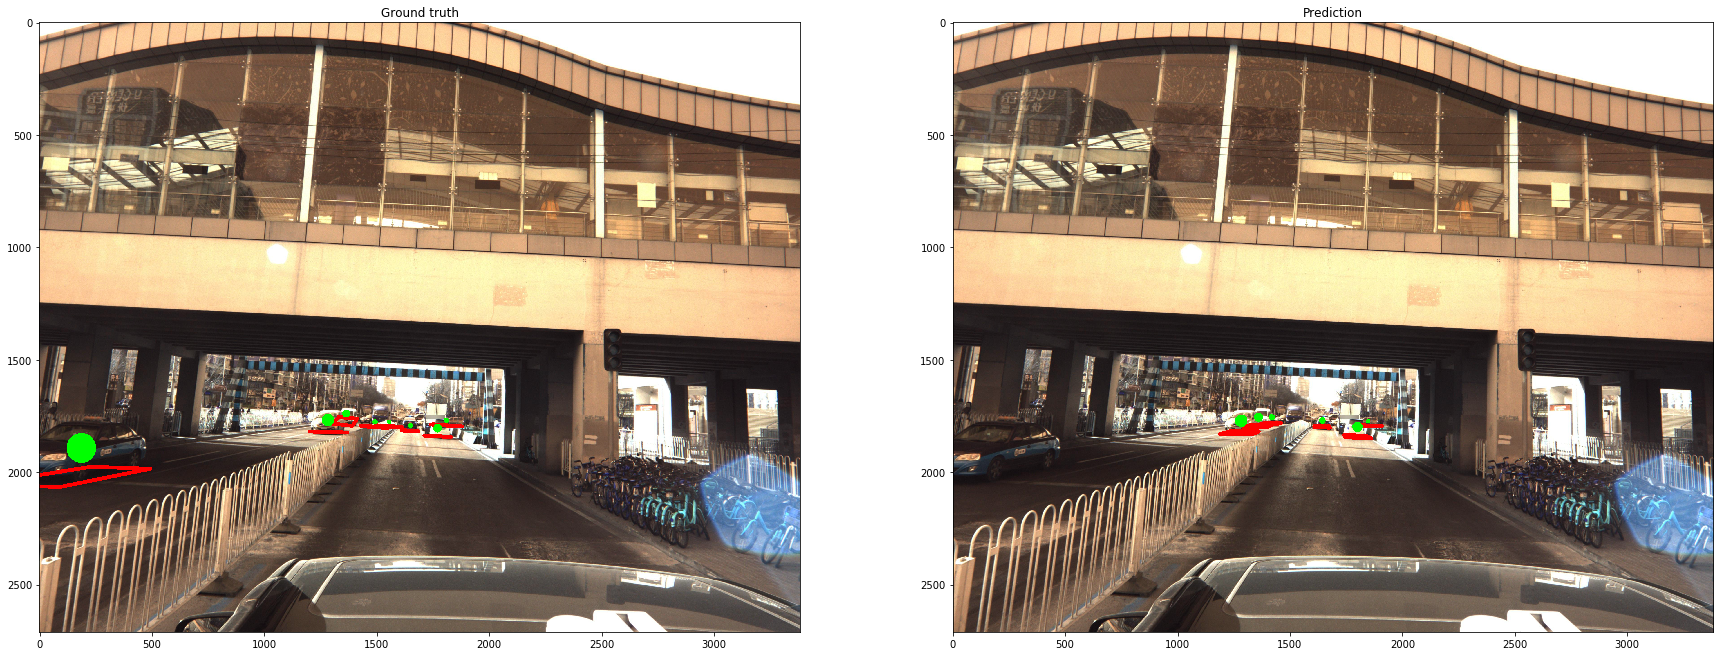

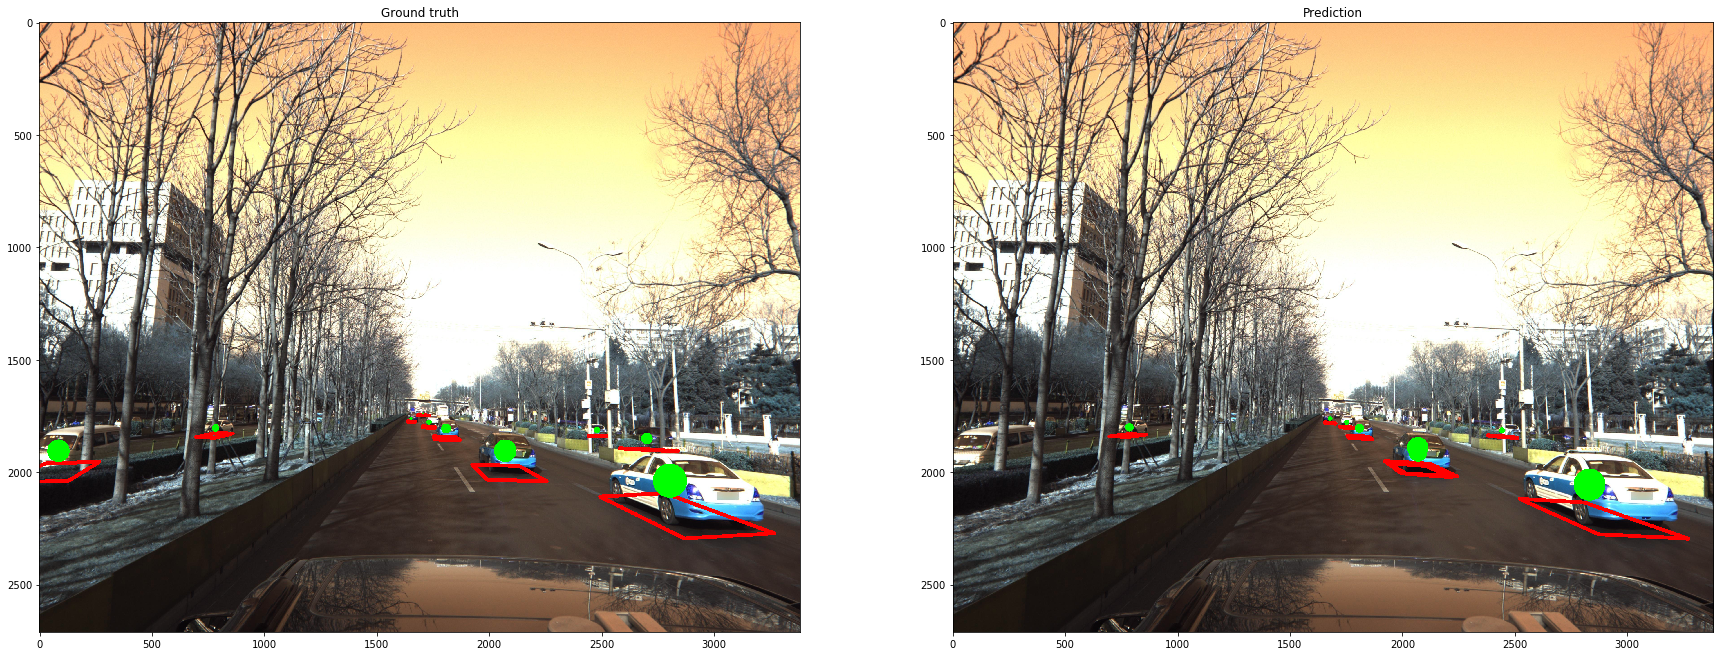

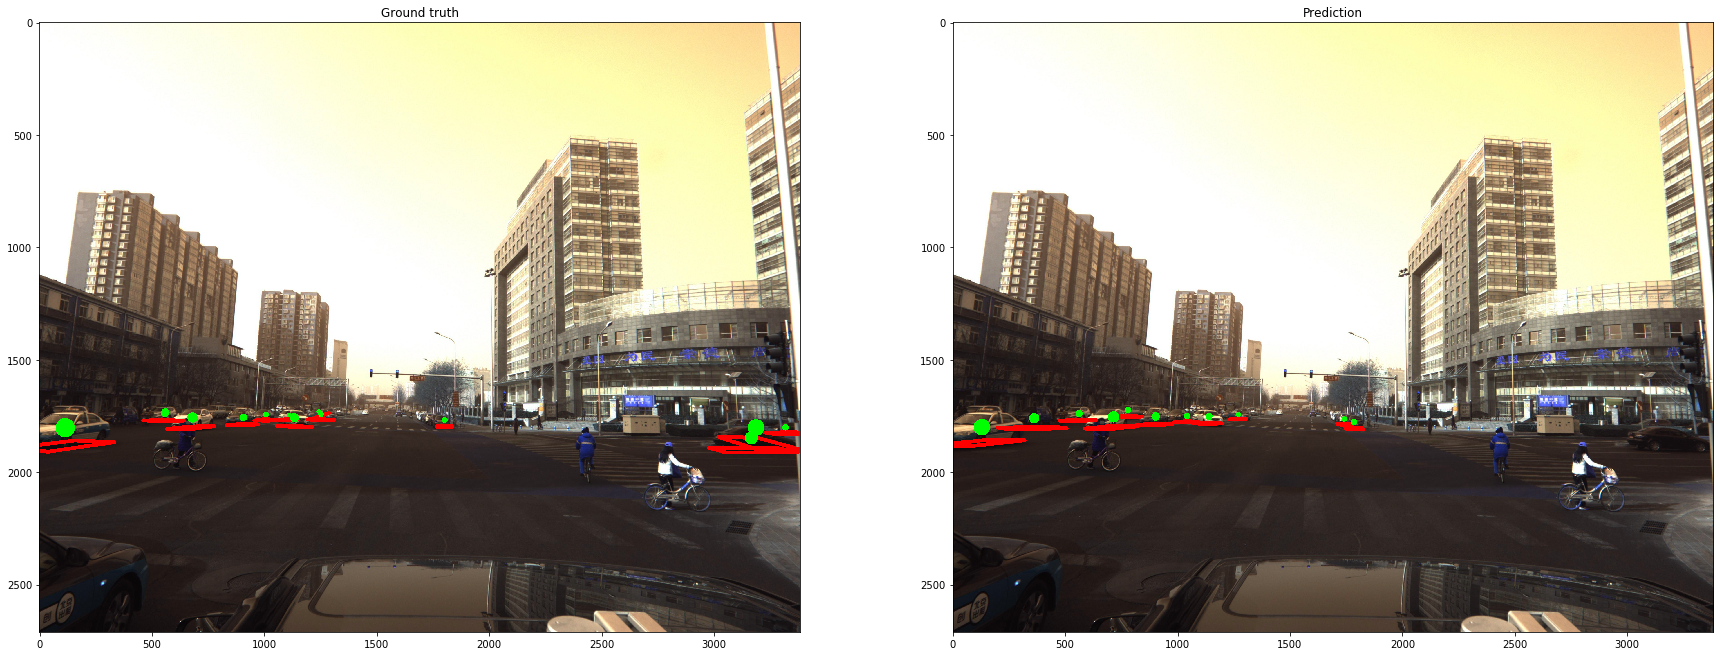

In [51]:
import gc
gc.collect()

for idx in range(4):
    data = dev_loader.dataset[idx]
    img, mask, regr = data["img"], data["mask"], data["regr"]
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()

    coords_pred = util.extract_coords(data, output[0])
    coords_true = util.extract_coords(data)

    img = io.load_image(dev_loader.dataset.dataset[idx].image_id)
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(graphics.draw_coords(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(graphics.draw_coords(img, coords_pred))
    plt.show()